# Coursera Capstone Project

## Introduction
<font color=blue>Besides coffee, milk tea becomes a popular beverage now. We plan to open a tea shop in San Diego, CA. There are many neighborhoods in San Diego city and the retail rental price varies among them.  So first we need to look for some neighborhoods already have good restaurants or cafes people like to go, second, the rental price should not be very high which might be over our budget.

    In this project,
        Step 1: Scrape San Diego neighborhoods and rental market data from website
        Step 2: Obtain the geographical data of each neighborhood
        Step 3: Get the categories applied to venues with Foursquare API
        Step 4: Use K-means to cluster the neighborhoods based on the categories and average rental price
        Step 5: Provide a discussion based on the clustering results
</font>

## Download and Explore Dataset

#### Scraping an html to get the list of neighborhoods and the average rental price in San Diego

In [1]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
import requests # library to handle requests
import urllib.request

import pandas as pd #library for data analysis
import numpy as np # library to handle data in a vectorized manner
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 122kB 7.9MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing tran

In [ ]:
# I don't use this website anymore, but another having Average Rent prices of each neighborhood in San Diego
# url = 'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'
# response = requests.get(url)
# soup = BeautifulSoup(response.content, 'html.parser')
# div = soup.find("div", {"aria-labelledby":"Neighborhoods_of_San_Diego"})
# results = [li.text for li in div.findAll('li')]

In [2]:
url = 'https://www.rentcafe.com/average-rent-market-trends/us/ca/san-diego/'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
div = soup.find("div", {"class":"table-neighborhood"})

In [3]:
column_names = ['Neighborhoods','AverageRent']
df = pd.DataFrame(columns = column_names)

In [4]:
table = div.find("table", {"id":"MarketTrendsAverageRentTable"})
row = table.findAll("tr", {"class":"current-row"})
row_marker = 0
for row in table.findAll("tr", {"class":"current-row"}):
    df.at[row_marker, 'Neighborhoods'] = row.find('th').text
    df.at[row_marker, 'AverageRent'] = row.find('td').text
    row_marker += 1

In [5]:
df['AverageRent']=df['AverageRent'].map(lambda x: x.lstrip('$'))
df['AverageRent']=df['AverageRent'].str.replace(',','')
df['AverageRent']=pd.to_numeric(df['AverageRent'], downcast='float')

In [6]:
df.loc[df['Neighborhoods'] == 'Clairemont Mesa West', ['Neighborhoods']] = 'Clairemont Mesa'

In [7]:
df.sort_values(by='Neighborhoods',inplace=True)

In [8]:
sd_df = df.reset_index(drop=True)

In [9]:
print("There are " + str(sd_df.shape[0]) + " neighborhoods in San Diego")

There are 122 neighborhoods in San Diego


In [10]:
#add two columns for Latitude and Longitude
sd_df['Latitude']=''
sd_df['Longitude']=''

In [11]:
sd_df.head()

,Neighborhoods,AverageRent,Latitude,Longitude
0,4S Ranch,2261.0,,
1,Allied Gardens,2105.0,,
2,Alta Vista,975.0,,
3,Alvarado Estates,1946.0,,
4,Azalea - Hollywood Park,1619.0,,


In [ ]:
#geocoder.google doesn't work, no return
#!pip install geocoder
#import geocoder
#lat_lng_coords = None
#while (lat_lng_coords is None):
#    g = geocoder.google('San Diego, CA')
#    lat_lng_coords = g.latlng

#latitude=lat_lng_coords[0]
#longitude=lat_lng_coords[1]

In [12]:
suffix = ', San Diego, CA'
row_marker = 0
for nghb in sd_df['Neighborhoods']:
    address = nghb + suffix
    geolocator = Nominatim(user_agent='SD_explorer')
    location = geolocator.geocode(address)
    if location != None:
        sd_df.at[row_marker, 'Latitude'] = location.latitude
        sd_df.at[row_marker, 'Longitude'] = location.longitude
    else:
        sd_df.at[row_marker, 'Latitude'] = None
        sd_df.at[row_marker, 'Longitude'] = None
    row_marker += 1


In [13]:
sd_df['Latitude']=pd.to_numeric(sd_df['Latitude'], downcast='float')
sd_df['Longitude']=pd.to_numeric(sd_df['Longitude'], downcast='float')
sd_df.dtypes

Neighborhoods     object
AverageRent      float32
Latitude         float32
Longitude        float32
dtype: object

In [14]:
nan_returns = sd_df['Latitude'].isnull().sum(axis = 0)
print("There are {} neighborhoods without Latitude and Longitude value returned".format(nan_returns))

There are 25 neighborhoods without Latitude and Longitude value returned


In [15]:
sd_df.head()

,Neighborhoods,AverageRent,Latitude,Longitude
0,4S Ranch,2261.0,NaN,NaN
1,Allied Gardens,2105.0,32.792686,-117.080437
2,Alta Vista,975.0,32.693340,-117.063156
3,Alvarado Estates,1946.0,32.774399,-117.091347
4,Azalea - Hollywood Park,1619.0,33.368637,-117.175911


<font>Not all neighborhoods' geographical parameters can be obtained, so I will try different name for those neighborhoods and delete those that I can't get the latitude and longitude at the end</font>

In [16]:
#drop the neighborhoods without latitude and longitude
sd_df=sd_df.dropna()
sd_df=sd_df.reset_index(drop=True)
sd_df.shape

(97, 4)

In [17]:
sd_df.head()

,Neighborhoods,AverageRent,Latitude,Longitude
0,Allied Gardens,2105.0,32.792686,-117.080437
1,Alta Vista,975.0,32.693340,-117.063156
2,Alvarado Estates,1946.0,32.774399,-117.091347
3,Azalea - Hollywood Park,1619.0,33.368637,-117.175911
4,Balboa Park,2411.0,32.731358,-117.146530


<font>Till now, I already have the clean dataset for exploring and cluster later.</font>

#### Create a map of San Diego with neighborhoods superimposed on top.

In [18]:
# create map of San Diego using latitude and longitude values
address = 'San Diego, CA'
geolocator = Nominatim(user_agent='SD_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_sandiego = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, nghbd in zip(sd_df['Latitude'], sd_df['Longitude'], sd_df['Neighborhoods']):
    label = '{}'.format(nghbd)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sandiego)  
    
map_sandiego

## Explore Neighborhoods in San Diego

#### Define Foursquare Credentials and Version

In [19]:
CLIENT_ID = 'SCIUXMLEPZJKICI1VOHG3TKUYIHTGO13DUBN3HB1NQIT40MH' # your Foursquare ID
CLIENT_SECRET = 'A3ZDFDKA22P4LZCMJQSWASZZYY1ENIG1RSXRKLQA2ISIPJHD' # your Foursquare Secret
VERSION = '20200712' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SCIUXMLEPZJKICI1VOHG3TKUYIHTGO13DUBN3HB1NQIT40MH
CLIENT_SECRET:A3ZDFDKA22P4LZCMJQSWASZZYY1ENIG1RSXRKLQA2ISIPJHD


***

#### Use Foursquare API to get the category applied to venues

In [20]:
categories_url='https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION)
cat_results=requests.get(categories_url).json()

In [21]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(cat_results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


In [22]:
sd_venues=sd_df.copy()
for cat in categories_list:
    sd_venues[cat[0]]=0

In [23]:
sd_venues.head()

,Neighborhoods,AverageRent,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Allied Gardens,2105.0,32.792686,-117.080437,0,0,0,0,0,0,0,0,0,0
1,Alta Vista,975.0,32.693340,-117.063156,0,0,0,0,0,0,0,0,0,0
2,Alvarado Estates,1946.0,32.774399,-117.091347,0,0,0,0,0,0,0,0,0,0
3,Azalea - Hollywood Park,1619.0,33.368637,-117.175911,0,0,0,0,0,0,0,0,0,0
4,Balboa Park,2411.0,32.731358,-117.146530,0,0,0,0,0,0,0,0,0,0


In [ ]:
def get_venues(lat,long, radius, categoryId):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)

    # make the GET request
    results=requests.get(url).json()['response']['totalResults']

    return results
    

In [ ]:
for i, row in sd_venues.iterrows():
    print(i, sd_venues.Neighborhoods.iloc[i])
    for cat in categories_list:
        sd_venues.loc[i, cat[0]]=get_venues(sd_venues.Latitude.iloc[i],sd_venues.Longitude.iloc[i], radius=1000, categoryId=cat[1])

#save the dataframe into a csv file
sd_venues.to_csv('venue_category.csv')

In [24]:
#There is call limitation of Foursqare API, so no need to call the API every time but get the data from the csv file saving the return value of Foursqaure API
sd_venues=pd.read_csv('venue_category.csv')
sd_venues=sd_venues.drop(sd_venues.columns[0], axis=1)
sd_venues.head()

,Neighborhoods,AverageRent,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Allied Gardens,2105.0,32.792686,-117.080440,0,2,1,8,2,6,17,0,19,0
1,Alta Vista,975.0,32.693340,-117.063156,1,2,1,7,2,4,8,1,6,0
2,Alvarado Estates,1946.0,32.774400,-117.091350,4,7,0,5,1,7,20,4,25,3
3,Azalea - Hollywood Park,1619.0,33.368637,-117.175910,0,0,0,1,1,2,0,0,1,0
4,Balboa Park,2411.0,32.731358,-117.146530,126,4,1,32,4,33,111,0,28,15


In [25]:
sd_venues.shape

(97, 14)

### Venues data processing. Converting categorical data into numerical data

In [26]:
X=sd_venues.values[:, 4:]
scaled_dataset = MinMaxScaler().fit_transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
sd_venues_scaled = pd.DataFrame(scaled_dataset)
sd_venues_scaled.columns = [c[0] for c in categories_list]
sd_venues_scaled.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.000000,0.030769,0.333333,0.038835,0.019802,0.034483,0.106918,0.000000,0.098446,0.000000
1,0.007937,0.030769,0.333333,0.033981,0.019802,0.017241,0.050314,0.016393,0.031088,0.000000
2,0.031746,0.107692,0.000000,0.024272,0.009901,0.043103,0.125786,0.065574,0.129534,0.021127
3,0.000000,0.000000,0.000000,0.004854,0.009901,0.000000,0.000000,0.000000,0.005181,0.000000
4,1.000000,0.061538,0.333333,0.155340,0.039604,0.267241,0.698113,0.000000,0.145078,0.105634


### Visualize the frequency of each category

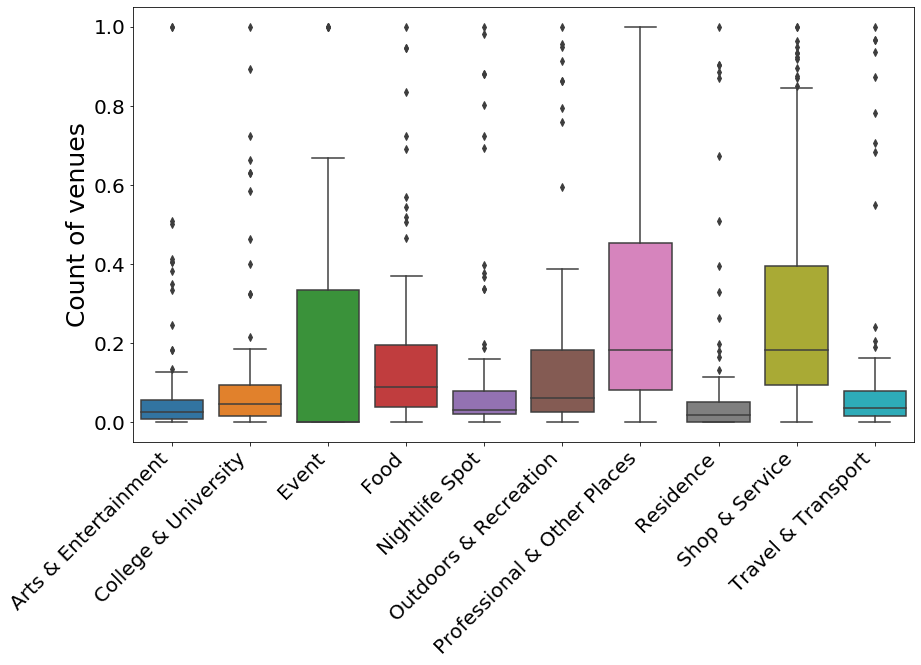

In [28]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(data=sd_venues_scaled)
ax.set_ylabel('Count of venues', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
plt.show()

## Cluster Neighborhoods

In [54]:
#K-means clustering algorithm is used for clustering
kclusters=4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sd_venues_scaled)
kmeans_labels = kmeans.labels_

#add the cluster labels column
sd_venues_clustered = sd_venues.copy()
sd_venues_clustered['ClusterLabels']=kmeans_labels

sd_venues_scaled_clustered=sd_venues_scaled.copy()
sd_venues_scaled_clustered['ClusterLabels']=kmeans_labels


## Examine the clusters

### Visualize the categories frequency of all clusters 

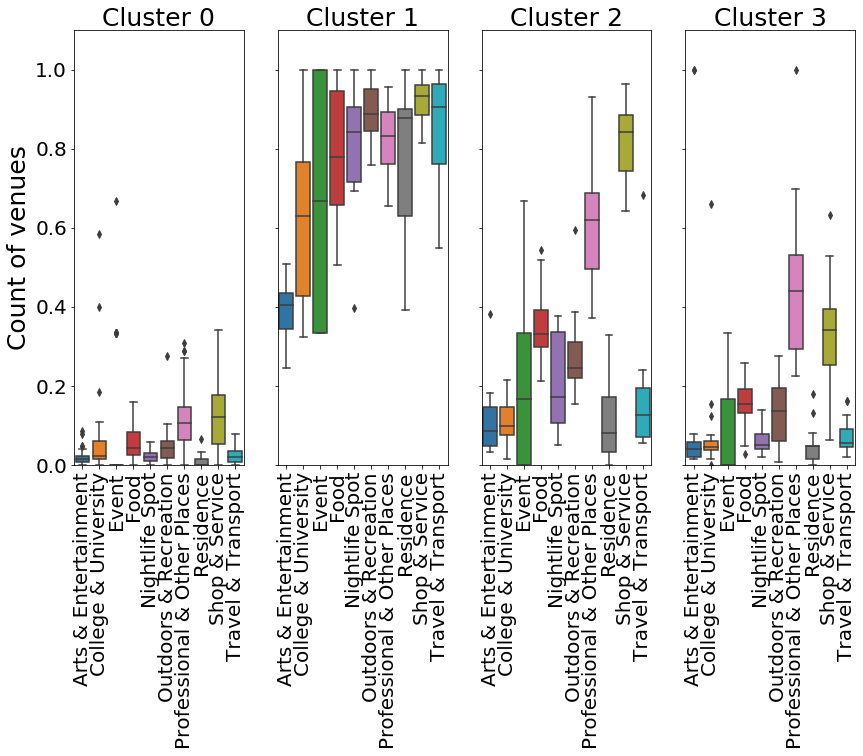

In [55]:
fig,axes= plt.subplots(1,kclusters,figsize=(14,8),sharey=True)

axes[0].set_ylabel('Count of venues', fontsize=25)

for k in range(0, kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = sd_venues_scaled_clustered[sd_venues_scaled_clustered['ClusterLabels'] == k].drop('ClusterLabels',1), ax=axes[k])

plt.show()

In [56]:
sd_venues_clustered.head()

,Neighborhoods,AverageRent,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,ClusterLabels
0,Allied Gardens,2105.0,32.792686,-117.080440,0,2,1,8,2,6,17,0,19,0,0
1,Alta Vista,975.0,32.693340,-117.063156,1,2,1,7,2,4,8,1,6,0,0
2,Alvarado Estates,1946.0,32.774400,-117.091350,4,7,0,5,1,7,20,4,25,3,0
3,Azalea - Hollywood Park,1619.0,33.368637,-117.175910,0,0,0,1,1,2,0,0,1,0,0
4,Balboa Park,2411.0,32.731358,-117.146530,126,4,1,32,4,33,111,0,28,15,3


### Visualize the average rent of all clusters

In [57]:
cluster_rent = sd_venues_clustered[['ClusterLabels', 'AverageRent']]
mean_rent = cluster_rent.groupby('ClusterLabels').mean()
print("Average Rent for each cluster: \n ", mean_rent)


Average Rent for each cluster: 
                 AverageRent
ClusterLabels             
0              1788.120690
1              2386.625000
2              2059.083333
3              1984.421053


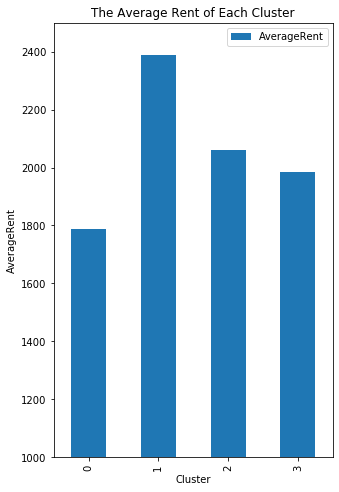

In [59]:
# generate bar chart

mean_rent.plot(kind='bar', figsize=(5, 8))
x1,x2,y1,y2=plt.axis()
plt.axis([x1,x2,1000,2500])
plt.title('The Average Rent of Each Cluster')
plt.ylabel('AverageRent')
plt.xlabel('Cluster')

plt.show()

In [60]:
# create map of San Diego using latitude and longitude values
address = 'San Diego, CA'
geolocator = Nominatim(user_agent='SD_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 4
# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colors=['red', 'yellow', 'blue', 'green']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sd_venues_clustered['Latitude'], sd_venues_clustered['Longitude'], sd_venues_clustered['Neighborhoods'], sd_venues_clustered['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color=colors[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
           
map_clusters

***

## Discussion: 
For average rent: Cluster1 > Cluster2 > Cluster3 > Cluster0.

For the category of Food, the frequency of Cluster1 is much higher than other clusters, and Cluster2 is the second.

## Conclusion:

Neighborhoods in Cluster 1 area might be the good choice for a milk tea shop because there are already many food services and people like to go those area for food and drink. But the rental cost is also high. So the final result also depends on the budget.

In [ ]:
print('Thank you for reviewing my project!')